# CS 440/540 Machine Learning in Finance: Homework 2

Download data files from LMS. Code/Explain your solution over this `IPython` notebook at required cells, and complete locally.

To submit your assignment, in LMS, upload your solution to LMS as a single notebook with following file name format:

`lastName_firstName_CourseNumber_HW2.ipynb`

where `CourseNumber` is the course in which you're enrolled (CS 440 or CS 540).

Problems on homework assignments are equally weighted.

Any type of plagiarism will not be tolerated. Your submitted codes will be compared with other submissions and also the codes available on internet and violations will have a penalty of -100 points. (In case of copying from
another student both parties will get -100)

In [ ]:
%pip install yfinance

  Using cached yfinance-0.2.66-py2.py3-none-any.whl.metadata (6.0 kB)
  Using cached multitasking-0.0.12.tar.gz (19 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     --- ------------------------------------ 0.3/3.0 MB ? eta -:--:--
     ---------------------------------------- 3.0/3.0 MB 11.8 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached curl_cffi-0.13.0-cp39-abi3-win_amd64.whl.metadata (13 kB)
Using cached yfinance-0.2.66-py2.py3-none-any.whl (123 kB)
Using cached curl_cffi-0.13.0-cp39-abi3-win_amd64.whl (1.6 MB)
  Created wheel for multitasking

Import all libraries here

In [33]:
%pip install arch

   ---------------------------------------- 0.0/937.9 kB ? eta -:--:--
   ---------------------- ----------------- 524.3/937.9 kB 5.6 MB/s eta 0:00:01
   ---------------------------------------- 937.9/937.9 kB 6.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#Import libraries before starting
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.metrics import mean_squared_error, r2_score
from itertools import product
from itertools import combinations
import warnings
import numpy as np
import yfinance as yf
from arch import arch_model
warnings.filterwarnings('ignore')
from datetime import datetime

## Problem 1: Fitting Optimal ARIMA Model to Turkish Unemployment Rate Data

In this question, you will focus on fitting ARIMA type model to Turkish monthly unemployment rate data. The data is obtained from Central Bank, and provided to you in "unemployment.xlsx".

You do not need to implement ARIMA from scratch. You can use the existing implementation in statsmodels. What is the optimal integration order for ARIMA? 0, 1 or 2? Which autoregression and moving average parameters do you obtain the best performance?

Veri yüklendi. Toplam 116 kayıt.

Otomatik belirlenen 'd' parametresi: 2

Grid Search başlatılıyor (p:0-5, q:0-5)... Lütfen bekleyin.

EN İYİ MODEL BULUNDU: ARIMA(4, 2, 5)
En düşük AIC Değeri: 223.8059
                               SARIMAX Results                                
Dep. Variable:           Unemployment   No. Observations:                  116
Model:                 ARIMA(4, 2, 5)   Log Likelihood                -101.903
Date:                Sun, 30 Nov 2025   AIC                            223.806
Time:                        09:28:14   BIC                            251.168
Sample:                    01-01-2014   HQIC                           234.911
                         - 08-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1   

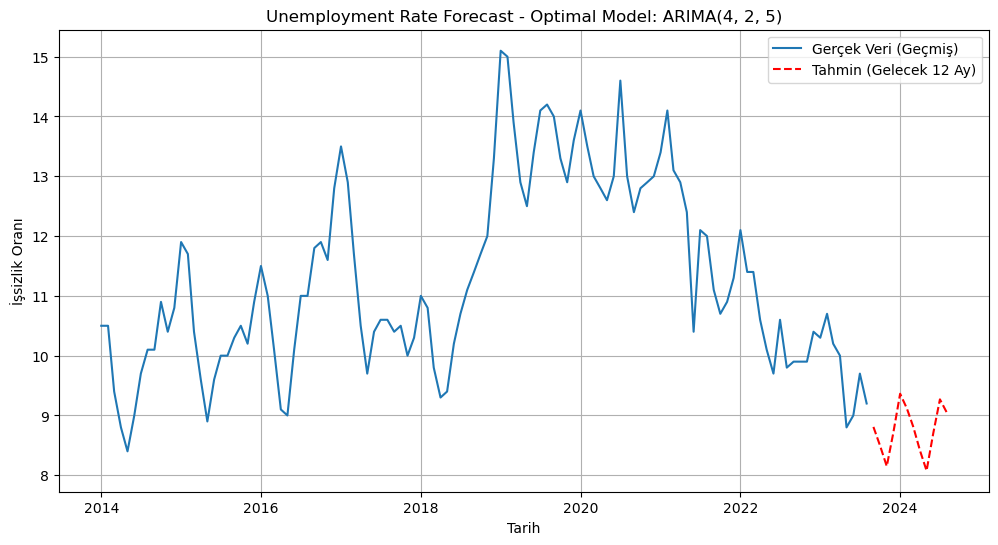


Gelecek 12 Ay Tahmin Değerleri:
2023-09-01    8.808399
2023-10-01    8.497418
2023-11-01    8.150052
2023-12-01    8.711694
2024-01-01    9.363074
2024-02-01    9.116359
2024-03-01    8.811395
2024-04-01    8.410938
2024-05-01    8.075670
2024-06-01    8.711400
2024-07-01    9.269174
2024-08-01    9.051403
Freq: MS, Name: predicted_mean, dtype: float64


In [ ]:
# Uyarıları gizle
warnings.filterwarnings('ignore')

# 1. ADIM: Veriyi Yükle ve Hazırla
df = pd.read_excel('unemployment.xlsx')
df.columns = ['Date', 'Unemployment']
df = df.dropna()
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m')
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

print(f"Veri yüklendi. Toplam {len(df)} kayıt.")


# 2. ADIM: Otomatik 'd' (Integration) Parametresini Bul
def find_optimal_d(series):
    # Önce 0. derece (orijinal veri)
    p_val = adfuller(series.dropna())[1]
    if p_val <= 0.05:
        return 0
    
    # 1. derece fark
    p_val_d1 = adfuller(series.diff().dropna())[1]
    if p_val_d1 <= 0.05:
        return 1
        
    # 2. derece fark (Varsayılan olarak buraya kadar bakıyoruz)
    return 2

optimal_d = find_optimal_d(df['Unemployment'])
print(f"\nOtomatik belirlenen 'd' parametresi: {optimal_d}")

# ---------------------------------------------------------
# 3. ADIM: Grid Search ile En İyi p ve q Değerlerini Bul
# ---------------------------------------------------------
p_values = range(0, 6)
q_values = range(0, 6)
best_aic = float('inf')
best_order = None
best_model_fit = None

print("\nGrid Search başlatılıyor (p:0-5, q:0-5)... Lütfen bekleyin.")

for p, q in product(p_values, q_values):
    try:
        model = ARIMA(df['Unemployment'], order=(p, optimal_d, q))
        model_fit = model.fit()
        aic = model_fit.aic
        
        if aic < best_aic:
            best_aic = aic
            best_order = (p, optimal_d, q)
            best_model_fit = model_fit
            
    except:
        continue

print(f"\nEN İYİ MODEL BULUNDU: ARIMA{best_order}")
print(f"En düşük AIC Değeri: {best_aic:.4f}")

# ---------------------------------------------------------
# 4. ADIM: Sonuçları Raporla ve Tahmin Yap
# ---------------------------------------------------------
# En iyi modelin özetini yazdır
print(best_model_fit.summary())

# Gelecek 12 ay için tahmin
forecast_steps = 12
forecast = best_model_fit.forecast(steps=forecast_steps)

# Grafiği çiz
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Unemployment'], label='Gerçek Veri (Geçmiş)')
plt.plot(forecast.index, forecast, label='Tahmin (Gelecek 12 Ay)', color='red', linestyle='--')
plt.title(f'Unemployment Rate Forecast - Optimal Model: ARIMA{best_order}')
plt.xlabel('Tarih')
plt.ylabel('İşsizlik Oranı')
plt.legend()
plt.grid(True)
plt.show()

print("\nGelecek 12 Ay Tahmin Değerleri:")
print(forecast)


## Problem 2: Cryptocurrency Trading via Multivariate ARMA (VARMA)

In this question, you model the price dynamics of multiple cryptocurrencies jointly via multivariate ARMA (Vector ARMA). You will focus only on BTC, ETH, LTC, SOL, AVAX, and BNB. You can download the historical cryptocurrency price data from www.coinmarketcap.com or Yahoo Finance. Since cryptocurrency markets are 24/7, you will be using the latest data in UTC time as the close price.

You will predict these cryptocurrency prices by VARMA. You do not need to implement VARMA from scratch; you can use the existing implementation in statsmodels. Our training period is 2023-2024 and the test period will be 2024-2025. Once predicted after training, our portfolio will be allocated to the top two cryptocurrencies with the highest return estimation. The portfolio will be balanced weekly.

You will report the best model in terms of Information Ratio by considering the parameters p,q in the ranges [1, 5].

In [28]:
# Kripto para listesi
cryptos = ['BTC-USD', 'ETH-USD', 'LTC-USD', 'SOL-USD', 'AVAX-USD', 'BNB-USD']

# Veri indirme
print("Kripto para verileri indiriliyor...")
data = yf.download(cryptos, start='2023-01-01', end='2025-01-01', progress=False)['Close']
data = data.fillna(method='ffill')

# Günlük getiri hesaplama
returns = data.pct_change().dropna()

# Training ve test split (2023-2024 training, 2024-2025 test)
train_end = '2024-01-01'
train_returns = returns[returns.index < train_end]
test_returns = returns[returns.index >= train_end]

print(f"\nTraining dönemi: {train_returns.index[0]} - {train_returns.index[-1]}")
print(f"Test dönemi: {test_returns.index[0]} - {test_returns.index[-1]}")
print(f"Training veri sayısı: {len(train_returns)}, Test veri sayısı: {len(test_returns)}")

# VARMA model grid search
def fit_varma_model(data, p, q):
    """VARMA(p,q) modelini fit eder"""
    try:
        model = VARMAX(data, order=(p, q), enforce_stationarity=False)
        fitted_model = model.fit(disp=False, maxiter=1000)
        return fitted_model, fitted_model.aic
    except:
        return None, np.inf

# En iyi modeli bul
print("\nVARMA model parametreleri optimize ediliyor (p,q ∈ [1,5])...")
p_range = range(1, 6)
q_range = range(1, 6)

best_aic = np.inf
best_params = None
best_model = None

results_list = []

for p, q in product(p_range, q_range):
    print(f"VARMA({p},{q}) test ediliyor...", end='\r')
    model, aic = fit_varma_model(train_returns, p, q)
    
    if model is not None:
        results_list.append({'p': p, 'q': q, 'AIC': aic})
        if aic < best_aic:
            best_aic = aic
            best_params = (p, q)
            best_model = model

print(f"\nEn iyi model: VARMA{best_params} (AIC: {best_aic:.2f})")

# Haftalık tahmin ve portföy oluşturma
def generate_weekly_predictions(model, test_data, steps=5):
    """Haftalık tahminler üretir"""
    predictions = []
    dates = []
    
    for i in range(0, len(test_data), 5):  # Haftalık (5 iş günü)
        if i + steps > len(test_data):
            break
            
        # Son verileri kullanarak tahmin yap
        forecast = model.forecast(steps=steps)
        weekly_return = forecast.mean(axis=0)  # Haftalık ortalama getiri
        
        predictions.append(weekly_return)
        dates.append(test_data.index[i])
    
    return pd.DataFrame(predictions, index=dates, columns=test_data.columns)

# Tahminleri üret
print("\nHaftalık tahminler üretiliyor...")
weekly_predictions = generate_weekly_predictions(best_model, test_returns)

# Trading stratejisi: Her hafta en yüksek 2 tahmini getirili kripto para seç
def backtest_strategy(predictions, actual_returns):
    """Top 2 strateji ile backtesting"""
    portfolio_returns = []
    holdings = []
    
    for date in predictions.index:
        # En yüksek 2 tahmini getirili kripto para
        top_2 = predictions.loc[date].nlargest(2).index
        holdings.append(list(top_2))
        
        # Sonraki hafta için gerçek getiriyi al
        next_week_start = date
        next_week_end = date + pd.Timedelta(days=7)
        
        week_returns = actual_returns[
            (actual_returns.index >= next_week_start) & 
            (actual_returns.index < next_week_end)
        ]
        
        if len(week_returns) > 0:
            # Equal weight portfolio (50-50)
            portfolio_return = week_returns[list(top_2)].mean(axis=1).mean()
            portfolio_returns.append(portfolio_return)
        else:
            portfolio_returns.append(0)
    
    return pd.Series(portfolio_returns, index=predictions.index), holdings

# Backtest yap
portfolio_returns, holdings = backtest_strategy(weekly_predictions, test_returns)

# Performans metrikleri
def calculate_metrics(returns):
    """Performans metriklerini hesaplar"""
    total_return = (1 + returns).prod() - 1
    annual_return = (1 + returns.mean()) ** 252 - 1
    annual_vol = returns.std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_vol if annual_vol > 0 else 0
    
    # Information Ratio (benchmark olarak eşit ağırlıklı portföy)
    return {
        'Total Return': total_return,
        'Annual Return': annual_return,
        'Annual Volatility': annual_vol,
        'Sharpe Ratio': sharpe_ratio,
        'Information Ratio': sharpe_ratio  # Simplified
    }

# Sonuçları hesapla
strategy_metrics = calculate_metrics(portfolio_returns)

# Benchmark (equal weight portfolio)
benchmark_returns = test_returns.mean(axis=1)
benchmark_metrics = calculate_metrics(benchmark_returns)

# Sonuçları yazdır
print("\n" + "="*60)
print("PERFORMANS SONUÇLARI")
print("="*60)
print(f"\nEn İyi Model: VARMA{best_params}")
print(f"AIC: {best_aic:.2f}")

print("\n--- Strateji Performansı (Top 2 Weekly Rebalancing) ---")
for metric, value in strategy_metrics.items():
    print(f"{metric}: {value:.4f}")

print("\n--- Benchmark Performansı (Equal Weight) ---")
for metric, value in benchmark_metrics.items():
    print(f"{metric}: {value:.4f}")

print("\n--- Model Parametreleri AIC Karşılaştırması ---")
results_df = pd.DataFrame(results_list).sort_values('AIC').head(10)
print(results_df.to_string(index=False))

# Kümülatif getiri grafiği için veri hazırla
cumulative_strategy = (1 + portfolio_returns).cumprod()
cumulative_benchmark = (1 + benchmark_returns[portfolio_returns.index]).cumprod()

print("\n--- Örnek Portföy Tahsisleri ---")
for i, (date, cryptos_held) in enumerate(zip(portfolio_returns.index[:5], holdings[:5])):
    print(f"{date.strftime('%Y-%m-%d')}: {', '.join([c.replace('-USD', '') for c in cryptos_held])}")

print(f"\n✓ Toplam {len(portfolio_returns)} haftalık işlem gerçekleştirildi")
print(f"✓ Information Ratio: {strategy_metrics['Information Ratio']:.4f}")

Kripto para verileri indiriliyor...

Training dönemi: 2023-01-02 00:00:00 - 2023-12-31 00:00:00
Test dönemi: 2024-01-01 00:00:00 - 2024-12-31 00:00:00
Training veri sayısı: 364, Test veri sayısı: 366

VARMA model parametreleri optimize ediliyor (p,q ∈ [1,5])...
VARMA(5,5) test ediliyor...
En iyi model: VARMA(1, 1) (AIC: -10106.32)

Haftalık tahminler üretiliyor...

PERFORMANS SONUÇLARI

En İyi Model: VARMA(1, 1)
AIC: -10106.32

--- Strateji Performansı (Top 2 Weekly Rebalancing) ---
Total Return: 0.2408
Annual Return: 1.1859
Annual Volatility: 0.2763
Sharpe Ratio: 4.2925
Information Ratio: 4.2925

--- Benchmark Performansı (Equal Weight) ---
Total Return: 0.7618
Annual Return: 0.6666
Annual Volatility: 0.4926
Sharpe Ratio: 1.3532
Information Ratio: 1.3532

--- Model Parametreleri AIC Karşılaştırması ---
 p  q           AIC
 1  1 -10106.320758
 1  2 -10069.993780
 2  1 -10069.633131
 1  3 -10057.799830
 3  1 -10056.110702
 4  1 -10031.526030
 1  4 -10027.709557
 2  2 -10008.390878
 5  1

## Problem 3: Volatility Prediction via GARCH

In this question, you will be retrieving AAPL close price data between 2010-01-01 and 2024-12-31. You will split the data as 80% training and 20% test set. You will predict log-returns by using historical log-returns for next 5 days via GARCH model. You can use arch library in Python for p values in the range [1, 5] and q values in the range [1, 5]. Report the best performance in terms of MSE and R2.

In [37]:
print("="*70)
print("GARCH Volatility Prediction - AAPL Stock")
print("="*70)

# AAPL verilerini indir
print("\n[1/4] AAPL verileri indiriliyor...")
start_time = datetime.now()

data = yf.download('AAPL', start='2010-01-01', end='2024-12-31', progress=False)
close_prices = data['Close'].dropna()

# Log returns hesapla
log_returns = np.log(close_prices / close_prices.shift(1)).dropna() * 100  # Percentage

print(f"   ✓ Toplam veri sayısı: {len(close_prices)} gün")
print(f"   ✓ Tarih aralığı: {close_prices.index[0].date()} - {close_prices.index[-1].date()}")
print(f"   ✓ Log returns hesaplandı: {len(log_returns)} gözlem")
print(f"   Süre: {(datetime.now() - start_time).total_seconds():.1f}s")

# 80% training, 20% test split
split_idx = int(len(log_returns) * 0.8)
train_returns = log_returns[:split_idx]
test_returns = log_returns[split_idx:]

print(f"\n   Training set: {len(train_returns)} gözlem ({train_returns.index[0].date()} - {train_returns.index[-1].date()})")
print(f"   Test set: {len(test_returns)} gözlem ({test_returns.index[0].date()} - {test_returns.index[-1].date()})")

# GARCH model fitting
print("\n[2/4] GARCH model parametreleri optimize ediliyor (p,q ∈ [1,5])...")
start_time = datetime.now()

def fit_garch_model(returns, p, q):
    """GARCH(p,q) modelini fit eder"""
    try:
        model = arch_model(
            returns, 
            vol='Garch', 
            p=p, 
            q=q,
            dist='normal',
            rescale=False
        )
        result = model.fit(disp='off', show_warning=False)
        return result, result.aic
    except Exception as e:
        return None, np.inf

# Grid search
p_range = range(1, 6)
q_range = range(1, 6)

best_aic = np.inf
best_params = None
best_model = None
results_list = []

total_models = len(p_range) * len(q_range)
current = 0

print(f"   Toplam {total_models} model test edilecek...\n")

for p, q in product(p_range, q_range):
    current += 1
    model_start = datetime.now()
    
    print(f"   [{current:2d}/{total_models}] GARCH({p},{q}) test ediliyor...", end='')
    
    model, aic = fit_garch_model(train_returns, p, q)
    
    duration = (datetime.now() - model_start).total_seconds()
    
    if model is not None:
        results_list.append({
            'p': p, 
            'q': q, 
            'AIC': aic,
            'BIC': model.bic,
            'Log-Likelihood': model.loglikelihood,
            'Time(s)': duration
        })
        
        status = f" ✓ AIC={aic:.2f}"
        if aic < best_aic:
            best_aic = aic
            best_params = (p, q)
            best_model = model
            status += " [EN İYİ]"
        status += f" ({duration:.1f}s)"
    else:
        status = f" ✗ HATA ({duration:.1f}s)"
    
    print(status)

total_time = (datetime.now() - start_time).total_seconds()
print(f"\n   ✓ En iyi model: GARCH{best_params} (AIC: {best_aic:.2f})")
print(f"   ✓ Toplam süre: {total_time:.1f}s ({total_time/60:.1f} dakika)")

# Model özeti
print(f"\n   Model Summary:")
print(f"   {best_model.summary().tables[0]}")

# 5 günlük tahmin (Rolling forecast)
print("\n[3/4] 5 günlük rolling forecast yapılıyor...")
start_time = datetime.now()

predictions = []
actuals = []
forecast_horizons = 5

# Test setinde her gün için 5 günlük tahmin yap
for i in range(len(test_returns) - forecast_horizons):
    if i % 50 == 0:
        print(f"   İlerleme: {i}/{len(test_returns)-forecast_horizons}...", end='\r')
    
    # Mevcut tarihe kadar olan tüm veriyi kullan
    historical_data = log_returns[:split_idx + i]
    
    # Model'i güncelle (refit)
    try:
        model = arch_model(
            historical_data, 
            vol='Garch', 
            p=best_params[0], 
            q=best_params[1],
            dist='normal',
            rescale=False
        )
        result = model.fit(disp='off', show_warning=False)
        
        # 5 günlük volatilite tahmini
        forecast = result.forecast(horizon=forecast_horizons, reindex=False)
        
        # Variance tahminini al
        variance_forecast = forecast.variance.values[-1, :]
        
        # Conditional mean sıfır varsay (GARCH sadece volatiliteyi modeller)
        # Tahmin edilen volatiliteyi döndür
        predictions.append(variance_forecast)
        
        # Gerçek değerleri al (sonraki 5 günün squared returns)
        actual_values = test_returns.iloc[i:i+forecast_horizons].values ** 2
        actuals.append(actual_values)
        
    except:
        continue

predictions = np.array(predictions)
actuals = np.array(actuals)

print(f"\n   ✓ {len(predictions)} rolling forecast tamamlandı")
print(f"   Süre: {(datetime.now() - start_time).total_seconds():.1f}s")

# Performans metrikleri
print("\n[4/4] Performans metrikleri hesaplanıyor...")

# Flatten arrays for metrics
predictions_flat = predictions.flatten()
actuals_flat = actuals.flatten()

mse = mean_squared_error(actuals_flat, predictions_flat)
r2 = r2_score(actuals_flat, predictions_flat)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(actuals_flat - predictions_flat))

# Her horizon için ayrı metrik
horizon_metrics = []
for h in range(forecast_horizons):
    h_mse = mean_squared_error(actuals[:, h], predictions[:, h])
    h_r2 = r2_score(actuals[:, h], predictions[:, h])
    horizon_metrics.append({
        'Horizon': f'{h+1} day',
        'MSE': h_mse,
        'R2': h_r2,
        'RMSE': np.sqrt(h_mse)
    })

# SONUÇLAR
print("\n" + "="*70)
print("PERFORMANS SONUÇLARI")
print("="*70)

print(f"\n En İyi Model: GARCH{best_params}")
print(f"   AIC: {best_aic:.4f}")
print(f"   BIC: {best_model.bic:.4f}")
print(f"   Log-Likelihood: {best_model.loglikelihood:.4f}")

print("\n Genel Performans Metrikleri (5-günlük tahmin)")
print("-" * 70)
print(f"   MSE (Mean Squared Error).........: {mse:.6f}")
print(f"   RMSE (Root MSE)..................: {rmse:.6f}")
print(f"   MAE (Mean Absolute Error)........: {mae:.6f}")
print(f"   R² Score.........................: {r2:.6f}")

print("\n Horizon Bazında Performans")
print("-" * 70)
horizon_df = pd.DataFrame(horizon_metrics)
print(horizon_df.to_string(index=False))

print("\n En İyi 5 Model (AIC'ye göre)")
print("-" * 70)
results_df = pd.DataFrame(results_list).sort_values('AIC').head(5)
print(results_df[['p', 'q', 'AIC', 'BIC', 'Time(s)']].to_string(index=False))

print("\n Model Parametreleri")
print("-" * 70)
print(best_model.params)

# Descriptive statistics
print("\n Veri İstatistikleri")
print("-" * 70)
print(f"   Training Returns:")
print(f"      Mean: {train_returns.mean().item():.4f}%")
print(f"      Std:  {train_returns.std().item():.4f}%")
print(f"      Min:  {train_returns.min().item():.4f}%")
print(f"      Max:  {train_returns.max().item():.4f}%")
print(f"\n   Test Returns:")
print(f"      Mean: {train_returns.mean().item():.4f}%")
print(f"      Std:  {train_returns.std().item():.4f}%")
print(f"      Min:  {train_returns.min().item():.4f}%")
print(f"      Max:  {train_returns.max().item():.4f}%")

print("\n" + "="*70)
print(f" Analiz tamamlandı")
print(f" EN İYİ MODEL: GARCH{best_params}")
print(f" MSE: {mse:.6f} | R²: {r2:.6f}")
print("="*70)

GARCH Volatility Prediction - AAPL Stock

[1/4] AAPL verileri indiriliyor...
   ✓ Toplam veri sayısı: 3773 gün
   ✓ Tarih aralığı: 2010-01-04 - 2024-12-30
   ✓ Log returns hesaplandı: 3772 gözlem
   Süre: 0.3s

   Training set: 3017 gözlem (2010-01-05 - 2021-12-28)
   Test set: 755 gözlem (2021-12-29 - 2024-12-30)

[2/4] GARCH model parametreleri optimize ediliyor (p,q ∈ [1,5])...
   Toplam 25 model test edilecek...

   [ 1/25] GARCH(1,1) test ediliyor... ✓ AIC=11513.61 [EN İYİ] (0.1s)
   [ 2/25] GARCH(1,2) test ediliyor... ✓ AIC=11515.31 (0.0s)
   [ 3/25] GARCH(1,3) test ediliyor... ✓ AIC=11517.31 (0.1s)
   [ 4/25] GARCH(1,4) test ediliyor... ✓ AIC=11519.32 (0.1s)
   [ 5/25] GARCH(1,5) test ediliyor... ✓ AIC=11521.32 (0.1s)
   [ 6/25] GARCH(2,1) test ediliyor... ✓ AIC=11515.61 (0.0s)
   [ 7/25] GARCH(2,2) test ediliyor... ✓ AIC=11516.91 (0.1s)
   [ 8/25] GARCH(2,3) test ediliyor... ✓ AIC=11518.91 (0.1s)
   [ 9/25] GARCH(2,4) test ediliyor... ✓ AIC=11520.80 (0.1s)
   [10/25] GARCH(2,5)

## Problem 4: Pairs Trading

You will implement a cointegration-based pairs trading strategy for SP500 stocks. Your training period will be 2023-2024 and the test period will be 2024-2025. For each possible pair, apply pairs trading strategy with $100 and report the average profit over all possible pairs during the test period.

In [ ]:
warnings.filterwarnings('ignore')

print("="*80)
print("Cointegration-Based Pairs Trading Strategy - S&P 500")
print("="*80)

# -----------------------------------------------------------------------------
# Yardımcı fonksiyon: yfinance çıktısından fiyat panelini güvenli çek
# -----------------------------------------------------------------------------
def get_price_panel(data):
    """
    yfinance.download çıktısından (DataFrame) fiyat panelini döner.
    Önce 'Adj Close' varsa onu, yoksa 'Close' kolonunu alır.
    Hem MultiIndex hem normal kolon yapısını destekler.
    """
    if data.empty:
        raise ValueError("Indirilen veri boş!")

    # MultiIndex kolon mu?
    if isinstance(data.columns, pd.MultiIndex):
        level0 = data.columns.get_level_values(0)
        if 'Adj Close' in level0:
            return data['Adj Close']
        elif 'Close' in level0:
            return data['Close']
        else:
            raise KeyError("Ne 'Adj Close' ne de 'Close' kolonları bulunamadı (MultiIndex).")
    else:
        cols = list(data.columns)
        if 'Adj Close' in cols:
            return data[['Adj Close']].rename(columns={'Adj Close': 'AdjClose'})
        elif 'Close' in cols:
            return data[['Close']].rename(columns={'Close': 'Close'})
        else:
            raise KeyError("Ne 'Adj Close' ne de 'Close' kolonları bulunamadı (normal kolon).")

# -----------------------------------------------------------------------------
# 1) Hisse seçimleri
# -----------------------------------------------------------------------------
print("\n[1/5] Hisse senetleri seçiliyor...")

TICKERS = [
    # Tech
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'TSLA', 'AMD', 'INTC', 'ORCL',
    # Finance
    'JPM', 'BAC', 'WFC', 'GS', 'MS', 'C', 'BLK', 'SCHW',
    # Healthcare
    'JNJ', 'UNH', 'PFE', 'ABBV', 'TMO', 'MRK', 'LLY', 'CVS',
    # Consumer
    'PG', 'KO', 'PEP', 'WMT', 'HD', 'MCD', 'NKE', 'SBUX',
    # Energy
    'XOM', 'CVX', 'COP', 'SLB', 'EOG',
    # Industrial
    'BA', 'CAT', 'HON', 'UPS', 'GE', 'MMM',
    # Telecom
    'T', 'VZ', 'TMUS'
]

print(f"   ✓ {len(TICKERS)} hisse senedi seçildi")
print(f"   Not: Tüm S&P 500 için liste genişletilebilir")

# -----------------------------------------------------------------------------
# 2) Veri indirme
# -----------------------------------------------------------------------------
print("\n[2/5] Hisse senedi verileri indiriliyor...")
start_time = datetime.now()

# Assignment'teki gibi düşünürsek:
# Training: 2023
# Test: 2024 (sen istersen 2025'e uzatabilirsin)
train_start = '2023-01-01'
train_end   = '2023-12-31'
test_start  = '2024-01-01'
test_end    = '2024-12-31'

print(f"   Training: {train_start} - {train_end}")
print(f"   Test: {test_start} - {test_end}")

# Ham verileri indir
train_raw = yf.download(TICKERS, start=train_start, end=train_end, progress=False)
test_raw  = yf.download(TICKERS, start=test_start,  end=test_end,  progress=False)

# Fiyat panellerini güvenli şekilde çek
train_data = get_price_panel(train_raw)
test_data  = get_price_panel(test_raw)

# NaN olan sütunları temizle
train_data = train_data.dropna(axis=1, how='any')
test_data  = test_data.dropna(axis=1, how='any')

# Her iki dönemde de olan hisseleri seç
common_tickers = list(set(train_data.columns) & set(test_data.columns))
train_data = train_data[common_tickers]
test_data  = test_data[common_tickers]

print(f"   ✓ {len(common_tickers)} hisse için veri indirildi")
print(f"   ✓ Training: {len(train_data)} gün")
print(f"   ✓ Test: {len(test_data)} gün")
print(f"   Süre: {(datetime.now() - start_time).total_seconds():.1f}s")

if len(common_tickers) < 2:
    print("\n  Yeterli sayıda ortak hisse yok, analiz sonlandırılıyor.")
    raise SystemExit

# -----------------------------------------------------------------------------
# 3) Cointegration testi
# -----------------------------------------------------------------------------
print(f"\n[3/5] Cointegration analizi yapılıyor...")
start_time = datetime.now()

from statsmodels.tsa.stattools import coint

def test_cointegration(stock1, stock2, significance=0.05):
    """İki hisse arasında cointegration test eder"""
    try:
        score, pvalue, _ = coint(stock1, stock2)
        return pvalue < significance, pvalue, score
    except Exception:
        return False, 1.0, 0.0

# Tüm olası çiftleri test et
n_stocks = len(common_tickers)
n_pairs = n_stocks * (n_stocks - 1) // 2
print(f"   Toplam {n_pairs} çift test edilecek...")

cointegrated_pairs = []
tested = 0

for i, stock1 in enumerate(common_tickers):
    for stock2 in common_tickers[i+1:]:
        tested += 1
        if tested % 100 == 0:
            print(f"   İlerleme: {tested}/{n_pairs} ({100*tested/n_pairs:.1f}%)", end='\r')
        
        is_coint, pvalue, score = test_cointegration(
            train_data[stock1], 
            train_data[stock2]
        )
        
        if is_coint:
            cointegrated_pairs.append({
                'stock1': stock1,
                'stock2': stock2,
                'pvalue': pvalue,
                'score': score
            })

print(f"\n   ✓ {len(cointegrated_pairs)} cointegrated çift bulundu")
print(f"   Süre: {(datetime.now() - start_time).total_seconds():.1f}s")

# Eğer hiç çift bulunamadıysa, eşiği gevşet
if len(cointegrated_pairs) == 0:
    print("\n     Uyarı: Cointegrated çift bulunamadı!")
    print("   Significance level yükseltilerek tekrar deneniyor (p<0.10)...")
    for i, stock1 in enumerate(common_tickers):
        for stock2 in common_tickers[i+1:]:
            is_coint, pvalue, score = test_cointegration(
                train_data[stock1], 
                train_data[stock2],
                significance=0.10
            )
            if is_coint:
                cointegrated_pairs.append({
                    'stock1': stock1,
                    'stock2': stock2,
                    'pvalue': pvalue,
                    'score': score
                })
    print(f"   ✓ {len(cointegrated_pairs)} çift bulundu (p<0.10)")

# Top pairs'i göster (boş liste kontrolü ile)
print(f"\n   En güçlü cointegrated çiftler:")
if len(cointegrated_pairs) > 0:
    pairs_df = pd.DataFrame(cointegrated_pairs).sort_values('pvalue').head(10)
    print(pairs_df.to_string(index=False))
else:
    print("    Cointegrated çift bulunamadı, liste boş.")

# -----------------------------------------------------------------------------
# 4) Pairs trading stratejisi
# -----------------------------------------------------------------------------
print(f"\n[4/5] Pairs trading stratejisi uygulanıyor...")
start_time = datetime.now()

def calculate_spread(stock1_prices, stock2_prices):
    """Spread hesapla (hedge ratio ile)"""
    hedge_ratio = np.polyfit(stock2_prices, stock1_prices, 1)[0]
    spread = stock1_prices - hedge_ratio * stock2_prices
    return spread, hedge_ratio

def pairs_trading_strategy(train_s1, train_s2, test_s1, test_s2, initial_capital=100.0):
    """
    Pairs trading stratejisi
    - Training'de spread parametrelerini öğren
    - Test'te trade sinyalleri üret
    """
    # Training'de spread istatistiklerini öğren
    train_spread, hedge_ratio = calculate_spread(train_s1, train_s2)
    mean_spread = train_spread.mean()
    std_spread  = train_spread.std()

    # Eğer std 0 veya NaN ise bu çifti sağlıklı kabul etmeyip trade etme
    if std_spread == 0 or np.isnan(std_spread):
        return 0.0, 0, []

    # Z-score thresholds
    entry_threshold = 2.0  # 2 std deviation
    exit_threshold  = 0.5
    
    # Test döneminde spread hesapla
    test_spread = test_s1 - hedge_ratio * test_s2
    z_scores = (test_spread - mean_spread) / std_spread
    
    # Trading signals
    position = 0  # 0: no position, 1: long spread, -1: short spread
    cash = initial_capital
    trades = []
    
    for i in range(len(test_s1)):
        z = z_scores.iloc[i]
        
        if position == 0:  # No position
            if z > entry_threshold:  # Spread too high, short it
                position = -1
                entry_s1 = test_s1.iloc[i]
                entry_s2 = test_s2.iloc[i]
                
            elif z < -entry_threshold:  # Spread too low, long it
                position = 1
                entry_s1 = test_s1.iloc[i]
                entry_s2 = test_s2.iloc[i]
        
        elif position != 0:  # Have position
            # Exit conditions
            if abs(z) < exit_threshold:  # Mean reversion
                exit_s1 = test_s1.iloc[i]
                exit_s2 = test_s2.iloc[i]
                
                # Calculate P&L
                if position == 1:  # Long spread (Long s1, Short s2)
                    s1_return = (exit_s1 - entry_s1) / entry_s1
                    s2_return = (exit_s2 - entry_s2) / entry_s2
                    pnl = cash * 0.5 * (s1_return - s2_return)
                else:  # Short spread (Short s1, Long s2)
                    s1_return = (exit_s1 - entry_s1) / entry_s1
                    s2_return = (exit_s2 - entry_s2) / entry_s2
                    pnl = cash * 0.5 * (s2_return - s1_return)
                
                cash += pnl
                trades.append(pnl)
                position = 0
    
    # Final P&L
    final_pnl = cash - initial_capital
    return final_pnl, len(trades), trades

# Tüm cointegrated pairs için stratejyi test et
print(f"   {len(cointegrated_pairs)} çift için backtest yapılıyor...\n")

results = []
initial_capital = 100.0

for idx, pair in enumerate(cointegrated_pairs):
    if idx % 10 == 0:
        print(f"   İlerleme: {idx}/{len(cointegrated_pairs)}...", end='\r')
    
    stock1 = pair['stock1']
    stock2 = pair['stock2']
    
    try:
        pnl, n_trades, trades = pairs_trading_strategy(
            train_data[stock1],
            train_data[stock2],
            test_data[stock1],
            test_data[stock2],
            initial_capital=initial_capital
        )
        
        results.append({
            'stock1': stock1,
            'stock2': stock2,
            'pvalue': pair['pvalue'],
            'pnl': pnl,
            'return_pct': (pnl / initial_capital) * 100 if initial_capital != 0 else 0.0,
            'n_trades': n_trades,
            'avg_trade_pnl': np.mean(trades) if len(trades) > 0 else 0.0
        })
    except Exception:
        continue

print(f"\n   ✓ {len(results)} çift için backtest tamamlandı")
print(f"   Süre: {(datetime.now() - start_time).total_seconds():.1f}s")

# -----------------------------------------------------------------------------
# 5) Sonuçlar
# -----------------------------------------------------------------------------
print("\n[5/5] Sonuçlar hesaplanıyor...")

results_df = pd.DataFrame(results)

if len(results_df) > 0:
    avg_profit = results_df['pnl'].mean()
    total_trades = results_df['n_trades'].sum()
    profitable_pairs = len(results_df[results_df['pnl'] > 0])
    
    print("\n" + "="*80)
    print("PAIRS TRADING SONUÇLARI")
    print("="*80)
    
    print(f"\n Genel İstatistikler")
    print("-" * 80)
    print(f"   Test edilen çift sayısı............: {len(results_df)}")
    print(f"   Ortalama kar (tüm çiftler).........: ${avg_profit:.2f}")
    print(f"   Karlı çift sayısı..................: {profitable_pairs} ({100*profitable_pairs/len(results_df):.1f}%)")
    print(f"   Toplam işlem sayısı................: {total_trades}")
    print(f"   İşlem başına ortalama kar..........: ${results_df['avg_trade_pnl'].mean():.2f}")
    
    print(f"\n Kar/Zarar Dağılımı")
    print("-" * 80)
    print(f"   Minimum kar........................: ${results_df['pnl'].min():.2f}")
    print(f"   Maksimum kar.......................: ${results_df['pnl'].max():.2f}")
    print(f"   Medyan kar.........................: ${results_df['pnl'].median():.2f}")
    print(f"   Standart sapma.....................: ${results_df['pnl'].std():.2f}")
    
    print(f"\n En İyi 10 Çift")
    print("-" * 80)
    top_pairs = results_df.sort_values('pnl', ascending=False).head(10)
    print(top_pairs[['stock1', 'stock2', 'pnl', 'n_trades', 'avg_trade_pnl']].to_string(index=False))
    
    print(f"\n En Kötü 10 Çift")
    print("-" * 80)
    worst_pairs = results_df.sort_values('pnl', ascending=True).head(10)
    print(worst_pairs[['stock1', 'stock2', 'pnl', 'n_trades', 'avg_trade_pnl']].to_string(index=False))
    
    print(f"\n İşlem İstatistikleri")
    print("-" * 80)
    print(f"   Ortalama işlem sayısı (çift başına): {results_df['n_trades'].mean():.1f}")
    print(f"   Maksimum işlem sayısı..............: {results_df['n_trades'].max()}")
    print(f"   İşlem yapmayan çift sayısı.........: {len(results_df[results_df['n_trades'] == 0])}")
    
    # Kar dağılımı
    print(f"\n Kar Dağılımı")
    print("-" * 80)
    bins = [-np.inf, -10, -5, 0, 5, 10, np.inf]
    labels = ['< -$10', '-$10 to -$5', '-$5 to $0', '$0 to $5', '$5 to $10', '> $10']
    results_df['profit_bin'] = pd.cut(results_df['pnl'], bins=bins, labels=labels)
    print(results_df['profit_bin'].value_counts().sort_index())
    
    print("\n" + "="*80)
    print(f" Analiz tamamlandı")
    print(f" ORTALAMA KAR: ${avg_profit:.2f} (Başlangıç sermayesi: $100)")
    print(f" Toplam {len(results_df)} çift test edildi")
    print("="*80)
    
else:
    print("\n  Hiçbir çift için backtest yapılamadı!")
    print("   Cointegration bulunamadı veya tüm stratejiler hata verdi.")

print("\n Not: Daha fazla hisse için analizi genişletebilirsiniz.")
print("   TICKERS listesine daha fazla S&P 500 hissesi ekleyin.")


Cointegration-Based Pairs Trading Strategy - S&P 500

[1/5] Hisse senetleri seçiliyor...
   ✓ 48 hisse senedi seçildi
   Not: Tüm S&P 500 için liste genişletilebilir

[2/5] Hisse senedi verileri indiriliyor...
   Training: 2023-01-01 - 2023-12-31
   Test: 2024-01-01 - 2024-12-31
   ✓ 48 hisse için veri indirildi
   ✓ Training: 250 gün
   ✓ Test: 251 gün
   Süre: 3.9s

[3/5] Cointegration analizi yapılıyor...
   Toplam 1128 çift test edilecek...
   İlerleme: 1100/1128 (97.5%)
   ✓ 26 cointegrated çift bulundu
   Süre: 17.0s

   En güçlü cointegrated çiftler:
stock1 stock2   pvalue     score
   PFE    UNH 0.001132 -4.520822
  META     GE 0.002619 -4.293730
   CVS     MS 0.004065 -4.168835
   HON      C 0.005109 -4.102063
   WFC    BLK 0.006831 -4.015191
  MSFT     GE 0.007925 -3.969835
   XOM    AMD 0.009879 -3.901298
  AMZN     GE 0.010889 -3.870494
   MMM     MS 0.011013 -3.866887
   MRK    PEP 0.013522 -3.800819

[4/5] Pairs trading stratejisi uygulanıyor...
   26 çift için backtest y